## Playing with Regression

This notebook will help us with testing different regression techniques, and eventually, test COBRA. 

So for now we will generate a random data-set and try some of the popular regression techniques on it, after it has been loaded to COBRA.

#### Imports

In [1]:
from pycobra.cobra import cobra
from pycobra.diagnostics import diagnostics
import numpy as np
%matplotlib inline

#### Setting up data set

In [2]:
# setting up our random data-set
rng = np.random.RandomState(1)

# D1 = train machines; D2 = create COBRA; D3 = calibrate epsilon, alpha; D4 = testing
n_features = 20
D1, D2, D3, D4 = 200, 200, 200, 200
D = D1 + D2 + D3 + D4
X = rng.uniform(-1, 1, D * n_features).reshape(D, n_features)
Y = np.power(X[:,1], 2) + np.power(X[:,3], 3) + np.exp(X[:,10]) 
# Y = np.power(X[:,0], 2) + np.power(X[:,1], 3)

# training data-set
X_train = X[:D1 + D2]
X_test = X[D1 + D2 + D3:D1 + D2 + D3 + D4]
X_eps = X[D1 + D2:D1 + D2 + D3]
# for testing
Y_train = Y[:D1 + D2]
Y_test = Y[D1 + D2 + D3:D1 + D2 + D3 + D4]
Y_eps = Y[D1 + D2:D1 + D2 + D3]

### Setting up COBRA

Let's up our COBRA machine with the data.

In [3]:
COBRA = cobra(X_train, Y_train, epsilon=0.5, default=False, random_state=0)

In the above line, we initialise COBRA with an epsilon value of $0.5$ - this is because we are aware of the distribution and 0.5 is a fair guess of what would be a "good" epsilon value, because the data varies from $-1$ to $1$. 

If we do not pass the $\epsilon$ parameter, it auto sets it as $\frac{\epsilon_{max} - \epsilon_{min}}{2}$, or if test_data is passed it sets it to an epsilon value optimised to the test-data.

It can be noticed that the `default` parameter is set as false: this is so we can walk you through what happens when COBRA is set-up, instead of the deafult settings being used.

We're now going to split our dataset into two parts, and shuffle data points.

In [4]:
COBRA.split_data(D1, D1 + D2, shuffle_data=True)

Let's load the default machines to COBRA.

In [5]:
COBRA.load_default()

We note here that further machines can be loaded using either the `loadMachine()` and `loadSKMachine()` methods. The only prerequisite is that the machine has a valid `predict()` method.

## Using COBRA's machines

We've created our random dataset and now we're going to use the default sci-kit machines to see what the results look like.

In [6]:
query = X_test[9].reshape(1, -1)

In [7]:
COBRA.machines

{'lasso': LassoLars(alpha=1.0, copy_X=True, eps=2.2204460492503131e-16,
      fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
      positive=False, precompute='auto', verbose=False),
 'random_forest': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
 'ridge': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=0, solver='auto', tol=0.001),
 'tree': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')}

In [8]:
COBRA.machines['lasso'].predict(query)

array([ 1.55459791])

In [9]:
COBRA.machines['tree'].predict(query)

array([ 0.22769628])

In [10]:
COBRA.machines['ridge'].predict(query)

array([ 0.06747291])

In [11]:
COBRA.machines['random_forest'].predict(query)

array([ 0.3382969])

## Aggregate!

By using the aggregate function we can combine our predictors.
You can read about the aggregation procedure either in the original COBRA paper or look around in the source code for the algorithm.

We start by loading each machine's predictions now.

In [12]:
COBRA.load_machine_predictions()

In [13]:
COBRA.predict(query)

0.20355644905114159

In [14]:
Y_test[9]

0.0095390633892067367

### Optimizing COBRA

To squeeze the best out of COBRA we make use of the COBRA diagnostics class. With a grid based approach to optimizing hyperparameters, we can find out the best epsilon value, number of machines (alpha value), and combination of machines.

Let's check the MSE for each of COBRAs machines:

In [15]:
cobra_diagnostics = diagnostics(COBRA, X_test, Y_test, load_MSE=True)

In [16]:
cobra_diagnostics.machine_MSE

{'COBRA': 0.1186812827420051,
 'lasso': 0.69378035831915863,
 'random_forest': 0.1087898042447215,
 'ridge': 0.17014683933748218,
 'tree': 0.16080252584960136}

This error is bound by the value $C\mathscr{l}^{\frac{-2}{M + 2}}$ upto a constant $C$, which is problem dependant. For more details, we refer the user to the original [paper](http://www.sciencedirect.com/science/article/pii/S0047259X15000950).

In [17]:
cobra_diagnostics.error_bound

0.005

### Playing with Data-Splitting

When we initially started to set up COBRA, we split our training data into two further parts - $D_k$, and $D_l$. 
This split was done 50-50, but it is upto us how we wish to do this. 
The following section will compare 20-80, 60-40, 50-50, 40-60, 80-20 and check for which case we get the best MSE values, for a fixed Epsilon (or use a grid).

In [18]:
cobra_diagnostics.optimal_split(X_eps, Y_eps)

((0.6, 0.4), 0.16127856452749259)

What we saw was the default result, with the optimal split ratio and the corresponding MSE. We can do a further analysis here by enabling the info and graph options, and using more values to split on.

In [19]:
split = [(0.05, 0.95), (0.10, 0.90), (0.20, 0.80), (0.40, 0.60), (0.50, 0.50), (0.60, 0.40), (0.80, 0.20), (0.90, 0.10), (0.95, 0.05)]

{(0.05, 0.95): 0.39262084148151344,
 (0.1, 0.9): 0.22715491182618358,
 (0.2, 0.8): 0.24066262191934482,
 (0.4, 0.6): 0.25176243012900951,
 (0.5, 0.5): 0.32890802098373911,
 (0.6, 0.4): 0.16127856452749259,
 (0.8, 0.2): 0.85840425483893001,
 (0.9, 0.1): 0.87760930708223073,
 (0.95, 0.05): 1.2414145213568437}

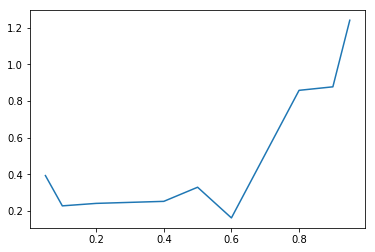

In [20]:
cobra_diagnostics.optimal_split(X_eps, Y_eps, split=split, info=True, graph=True)

### Alpha, Epsilon and Machines

The following are methods to idetify the optimal epislon values, alpha values, and combination of machines. 
The grid methods allow for us to predict for a single point the optimal alpha/machines and epsilon combination.

In [21]:
cobra_diagnostics.optimal_epsilon(X_eps, Y_eps, line_points=100)

(0.70018379287582377, 0.14676391327075944)

In [22]:
cobra_diagnostics.optimal_alpha(X_eps, Y_eps, info=True)

{1: 1.3770681356163277,
 2: 0.36330962313779791,
 3: 0.22184955956802241,
 4: 0.32890802098373911}

In [23]:
cobra_diagnostics.optimal_machines(X_eps, Y_eps, info=True)

{('lasso',): 0.67305998753716922,
 ('random_forest',): 0.21212098528993584,
 ('random_forest', 'lasso'): 0.21212098528993584,
 ('ridge',): 0.15102495085167283,
 ('ridge', 'lasso'): 0.15102495085167283,
 ('ridge', 'random_forest'): 0.12856244062945194,
 ('ridge', 'random_forest', 'lasso'): 0.12856244062945194,
 ('ridge', 'tree'): 0.29304405824493457,
 ('ridge', 'tree', 'lasso'): 0.29304405824493457,
 ('ridge', 'tree', 'random_forest'): 0.32890802098373911,
 ('ridge', 'tree', 'random_forest', 'lasso'): 0.32890802098373911,
 ('tree',): 0.30387747420693395,
 ('tree', 'lasso'): 0.30387747420693395,
 ('tree', 'random_forest'): 0.256264208732493,
 ('tree', 'random_forest', 'lasso'): 0.256264208732493}

In [24]:
cobra_diagnostics.optimal_alpha_grid(X_eps[0], Y_eps[0], line_points=100)

((4, 0.28007351715032952), 0.0016800595281319843)

In [25]:
cobra_diagnostics.optimal_machines_grid(X_eps[0], Y_eps[0], line_points=100)

((('ridge', 'tree', 'lasso'), 0.3150827067941207), 0.0002692832977726628)

Increasing the number of line points helps in finding a better optimal value. These are the results for the same point. The MSEs are to the second value of the tuple.

With 10:
((('ridge', 'random_forest', 'lasso'), 1.1063905961135443), 0.96254542159345469)
 
With 20: 
((('tree', 'random_forest'), 0.87346626008964035), 0.53850941611803993)

With 50:
((('ridge', 'tree'), 0.94833479666875231), 0.48256303899450931)

With 100:
((('ridge', 'tree', 'random_forest'), 0.10058096328304948), 0.30285776885759158)

With 200: 
((('ridge', 'tree', 'lasso'), 0.10007553130675276), 0.30285776885759158)